In [1]:
import combinatorial_peptide_pooling as cpp
import pandas as pd
import seaborn as sn
import numpy as np
from math import comb
from matplotlib import pyplot as plt
import time
import tqdm
import pymc as pm
import arviz as az
import random
from scipy import stats

# Algorithm statistics

### Number of pools

In [ ]:
results_time_fixI4 = pd.DataFrame(columns = ['N_pools', '# of peptides', 'Time (s)'])

for n in range(15, 20):
    results_time = dict()
    for i in tqdm.tqdm(range(50, 1000)):
        start_time = time.time()
        b, lines = cpp.address_rearrangement_AU(n_pools=n, iters=4, len_lst=i)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results_time[i] = elapsed_time
    results_time = pd.DataFrame.from_dict(results_time, orient = 'index')
    results_time = results_time.reset_index()
    results_time.columns = ['# of peptides', 'Time (s)']
    results_time['N_pools'] = n
    results_time_fixI4  = pd.concat([results_time_fixI4, results_time])

In [ ]:
sn.lineplot(data = results_time_fix4, x = '# of peptides', y = 'Time (s)', hue = 'N_pools')

### Peptide occurrence

In [ ]:
results_time_fixN20 = pd.DataFrame(columns = ['Peptide occurrence', '# of peptides', 'Time (s)'])

for iters in range(4, 7):
    results_time = dict()
    for i in tqdm.tqdm(range(50, 1000)):
        start_time = time.time()
        b, lines = cpp.address_rearrangement_AU(n_pools=20, iters=iters, len_lst=i)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results_time[i] = elapsed_time
    results_time = pd.DataFrame.from_dict(results_time, orient = 'index')
    results_time = results_time.reset_index()
    results_time.columns = ['# of peptides', 'Time (s)']
    results_time['Peptide occurrence'] = iters
    results_time_fixN20  = pd.concat([results_time_fixN20, results_time])

In [ ]:
sn.lineplot(data = results_time_fixN20, x = '# of peptides', y = 'Time (s)', hue = 'Peptide occurrence')

### Balance

In [ ]:
results_balance_fixN16_fixI4 = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    b, lines = cpp.address_rearrangement_AU(n_pools=16, iters=4, len_lst=i)
    results_balance_fixN16_fixI4[i] = b
    
balance = pd.DataFrame.from_dict(results_balance_fixN16_fixI4, orient = 'index')    
balance['perfect'] = 0
for i in list(balance.index):
    balance['perfect'].loc[i] = int(i*4/16)
    
for i in list(balance.index):
    for y in balance.columns:
        if y != 'perfect':
            balance[y].loc[i] = balance[y].loc[i] - balance['perfect'].loc[i]

In [ ]:
balance

In [ ]:
plot = sn.stripplot(data = balance.drop('perfect', axis=1).T, jitter = 0.1, size = 10)
plot.axhline(0, ls='--')
plot.set_ylim(-7, 7)
plot.set_xlabel('Number of peptides')
plot.set_ylabel('Balance_perfect - Balance_actual')

### Errors

In [ ]:
def random_amino_acid_sequence(length):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    return ''.join(random.choice(amino_acids) for _ in range(length))

length = 2000
sequence = random_amino_acid_sequence(length)
lst_all = []
for i in range(0, len(sequence), 5):
    ps = sequence[i:i+17]
    if len(ps) == 17:
        lst_all.append(ps)

n_pools = 18
iters = 6
simulation_results_fixN18_fixI6 = pd.DataFrame(columns = ['Peptide', 'Address', 'Epitope', 'Act Pools',
                                        '# of pools', '# of epitopes', '# of peptides', 'Remained', '# of lost',
                                           'Right peptide', 'Right epitope', 'Len'])

for i in tqdm.tqdm(range(100, 400, 100)):

    b, lines = cpp.address_rearrangement_AU(n_pools=n_pools, iters=iters, len_lst=i)
    lst = lst_all[:i]
    pools, peptide_address = cpp.pooling(lst=lst, addresses=lines, n_pools=n_pools)
    check_results = cpp.run_experiment(lst=lst, peptide_address=peptide_address, ep_length=8,
                              pools=pools, iters=iters, n_pools=n_pools, regime='with dropouts')
    check_results['Len'] = i
    simulation_results_fixN18_fixI6 = pd.concat([simulation_results_fixN18_fixI6, check_results])

In [ ]:
ax = sn.boxplot(data = simulation_results_fixN18_fixI6[simulation_results_fixN18_fixI6['# of lost'] > 3],
                x = '# of lost', y = '# of peptides', hue = 'Len')

### Number of pools - Peptide occurrence - Number of peptides

In [4]:
data= pd.DataFrame(columns = ['N_pools', 'Peptide occurrence', '# of peptides'])

for n in tqdm.tqdm(range(8, 13)):
    for i in range(2, 12):
        row = pd.DataFrame({'N_pools':n, 'Peptide occurrence':i, '# of peptides':comb(n, i)}, index=[0])
        data = pd.concat([data, row])

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 190.54it/s]


<Axes: xlabel='Peptide occurrence', ylabel='# of peptides'>

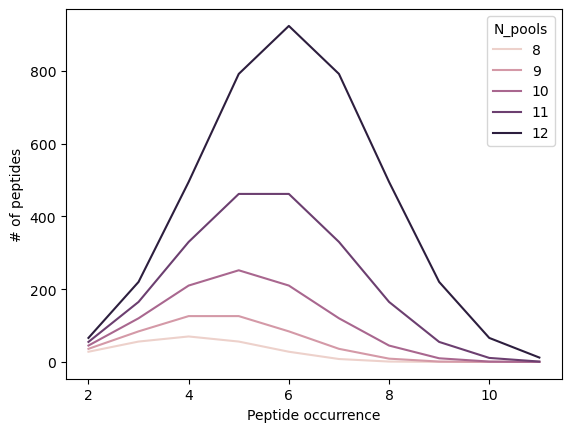

In [5]:
sn.lineplot(data = data, x='Peptide occurrence', y='# of peptides', hue = 'N_pools')

# Experiment results

### Flow cytometry

In [ ]:
results = pd.read_excel('flow_results.xlsx')
results['well_type'][results['well_type'] == 'allmix_5x_dilution'] = 'allmix_5x'
results['well_type'][results['well_type'] == 'allmix_25x_dilution'] = 'allmix_25x'

results['GFPpos_of_Jurkat_perc_log10'] = np.log10(results['GFPpos_of_Jurkat_perc']/100)
results['GFPpos_of_Jurkat_perc_ln'] = np.log(results['GFPpos_of_Jurkat_perc']/100)

plt.figure(figsize=(10, 6))
ax = sn.scatterplot(data = results[results['well_type'].str.contains('pool')],
                   x = 'well_type', y = 'GFPpos_of_Jurkat_perc_log10', color = '#0c5394')
plt.ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_title('TCR6.3: SSANNCTFEYVSQPFLM or CTFEYVSQPFLMDLEGK', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)


### Microscopy

In [ ]:
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = np.log10(list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values) + list(incu.loc['H'].values))
inds = ['pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6','pool7', 'pool8', 'pool9', 'pool10', 'pool11',
        'pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6', 'pool7', 'pool8', 'pool9', 'pool10', 'pool11',
        'pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6', 'pool7', 'pool8', 'pool9', 'pool10', 'pool11',
       'pept', 'pept', 'pept', 'all', 'all5', 'all25', 'un', 'un', 'un', 'PMA', 'PMA', 'PMA']
incu = pd.DataFrame(columns = ['Pool', 'Value'])
incu['Pool'] = inds
incu['Value'] = cell_i

plt.figure(figsize=(10, 6))
ax = sn.scatterplot(data = incu,
                   x = 'Pool', y = 'Value', color = '#0c5394')
plt.ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_title('TCR6.3: SSANNCTFEYVSQPFLM or CTFEYVSQPFLMDLEGK', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)

### Flow cytometry VS Microscopy

In [ ]:
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = np.log10(list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values) + list(incu.loc['H'].values))
cell_f = list(results['GFPpos_of_Jurkat_perc_log10'][(results['Cell_line'] == 'TCR6_3')])
ax = sn.regplot(x = cell_f, y = cell_i)
ax.set_title('TCR6_3', fontsize=8)
ax.set_ylabel('Log10 of number of activated T cells (incucyte)')
ax.set_xlabel('Log10 of activated T cell percentage (flow cytometry)')

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cell_f, cell_i)
r_squared = r_value**2
print(round(r_squared, 2))

# Model

In [ ]:
# Data
## Flow cytometry
results = pd.read_excel('flow_results.xlsx')
cell_f = list(results['GFPpos_of_Jurkat_perc'][(results['Cell_line'].str.contains('TCR6_3'))
                                 & (results['well_type'].str.contains('pool'))])
## Microscopy
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values)
cell_i = cell_i/sum(cell_i)*100

## Indices
inds = inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

### Flow cytometry

In [ ]:
coords = dict(pool=range(12), component=("positive", "negative"))

with pm.Model(coords=coords) as alternative_model:
    # 2 normal 'source' distributions for the positive and negative pools
    source = pm.TruncatedNormal(
        "source",
        mu=np.array([10, 0.5]),
        sigma=np.array([0.5, 0.1]),
        dims="component",
        lower=0,
    )

    # Each pool is assigned a 0/1 (could adjust the prior probability here given that we
    # know negatives are more likely a priori)
    component = pm.Bernoulli("assign", 0.5, dims="pool")

    # Each pool has a normally distributed response whose mu comes from either the
    # postive or negative source distribution
    pool_dist = pm.TruncatedNormal(
        "pool_dist",
        mu=source[component],
        sigma=pm.Exponential("sigma", 1),
        lower=0,
        dims="pool",
    )

    # Likelihood, where the data indices pick out the relevant pool from pool
    pm.TruncatedNormal(
        "lik",
        mu=pool_dist[inds],
        sigma=pm.Exponential("sigma_data", 1),
        observed=cell_f,
        lower=0,
    )

    idata_alt = pm.sample()

pm.model_to_graphviz(alternative_model)

In [ ]:
with alternative_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_alt)

ax = az.plot_ppc(posterior_predictive, num_pp_samples=100)

In [ ]:
posterior = az.extract(idata_alt)
print(posterior["assign"].mean(dim="sample").to_dataframe())

In [ ]:
idx = list(posterior["assign"].mean(dim="sample").to_dataframe()['assign'])*3
probs = pd.DataFrame(columns = ['Probs'])
probs['Probs'] = idx

_, ax = plt.subplots(figsize=(6, 3))
ax.bar(cell_f, 1-probs['Probs'], width=0.1, label="idx==0", color="b")
ax.bar(cell_f, probs['Probs'], bottom=1-probs['Probs'], width=0.1, label="idx==1", color="r")
ax.scatter(cell_f, [-0.1]*36)

### Microscopy

In [ ]:
coords = dict(pool=range(12), component=("positive", "negative"))

with pm.Model(coords=coords) as alternative_model:
    # 2 normal 'source' distributions for the positive and negative pools
    source = pm.TruncatedNormal(
        "source",
        mu=np.array([6, 0.5]),
        sigma=np.array([0.5, 0.1]),
        dims="component",
        lower=0,
    )

    # Each pool is assigned a 0/1 (could adjust the prior probability here given that we
    # know negatives are more likely a priori)
    component = pm.Bernoulli("assign", 0.5, dims="pool")

    # Each pool has a normally distributed response whose mu comes from either the
    # postive or negative source distribution
    pool_dist = pm.TruncatedNormal(
        "pool_dist",
        mu=source[component],
        sigma=pm.Exponential("sigma", 1),
        lower=0,
        dims="pool",
    )

    # Likelihood, where the data indices pick out the relevant pool from pool
    pm.TruncatedNormal(
        "lik",
        mu=pool_dist[inds],
        sigma=pm.Exponential("sigma_data", 1),
        observed=cell_i,
        lower=0,
    )

    idata_alt = pm.sample()

pm.model_to_graphviz(alternative_model)

In [ ]:
with alternative_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_alt)

ax = az.plot_ppc(posterior_predictive, num_pp_samples=100)

In [ ]:
posterior = az.extract(idata_alt)
print(posterior["assign"].mean(dim="sample").to_dataframe())

In [ ]:
idx = list(posterior["assign"].mean(dim="sample").to_dataframe()['assign'])*3
probs = pd.DataFrame(columns = ['Probs'])
probs['Probs'] = idx

_, ax = plt.subplots(figsize=(6, 3))
ax.bar(cell_i, 1-probs['Probs'], width=0.1, label="idx==0", color="b")
ax.bar(cell_i, probs['Probs'], bottom=1-probs['Probs'], width=0.1, label="idx==1", color="r")
ax.scatter(cell_i, [-0.1]*36)